# header

In [11]:
'''
function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
}

setInterval(ConnectButton,60000);
'''

from google.colab import drive
from os import chdir

drive.mount('/content/drive')
project_path = '/content/drive/MyDrive/Gproject/MIT_glyco'
chdir(project_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
import pandas as pd
import numpy as np

import os
from os.path import exists
print(os.getcwd()) # current working directory

update = False

/content/drive/MyDrive/Gproject/MIT_glyco


In [13]:
load_name = "./data/data_for_ml.csv"
protein_list = list(pd.read_csv(load_name).protein.unique())
protein_augmented = [name for name in protein_list if exists(f'./data/data_for_ml(augmented)/{name}.csv')]

dataset = []
for name in protein_augmented:
    load_path = f'./data/data_for_ml(augmented)/{name}.csv'
    dataset.append(pd.read_csv(load_path))
dataset = pd.concat(dataset, axis=0).reset_index(drop=True)

positive = dataset[dataset['positivity']==1]

print("total number of proteins:          ", len(protein_list))
print("total number of augmented proteins:", len(protein_augmented))
print("total number of positive sites:    ", len(positive))

total number of proteins:           272
total number of augmented proteins: 89
total number of positive sites:     185


## parameter settings

In [14]:
from src.Data import *
from src.Preprocessing import *
from src.models import *

variables = xy_variables()
test_size = 0.2
valid_size = test_size/(1-test_size)

import random
random_state = 1
n_cv = 20

hpo_counts = 30
hpo_config = {
    "n_layers" : range(1,11),
    "n_neurons" : [16, 32, 64, 128, 256]
}
metrics = ['rnn_layers', 'rnn_neurons', 'dnn_layers', 'dnn_neurons', 
           'epoch', 'time', 'loss', 'val_loss', 'test_loss', 'accuracy', 'precision', 'recall', 'f1']
method = "random"

# model

In [15]:
model_name = 'augmented_rnn_basic'
x_charge = pd.read_csv('./data/from_Krishna/features-all-names.csv').name.to_list()[:-1]

x_cts   = variables.x_cts_original + x_charge
x_cat   = variables.x_cat_original
y_label = variables.y_label

print(f"{len(x_cts)} x_cts")
print(f"{len(x_cat)} x_cat: {x_cat}")
print(f"{len(y_label)} y_label: {y_label}")

data_x, data_y = df_to_dummy(dataset, x_cts, x_cat, y_label)
display(dict(zip(range(len(data_x.columns)), data_x.columns)))

168 x_cts
2 x_cat: ['SEQ', 'SS']
1 y_label: ['positivity']
dummy x shape: (59027, 191)
dummy y shape: (59027, 1)


{0: 'ASA',
 1: 'Phi',
 2: 'Psi',
 3: 'Theta(i-1=>i+1)',
 4: 'Tau(i-2=>i+2)',
 5: 'HSE_alpha_up',
 6: 'HSE_alpha_down',
 7: 'P(C)',
 8: 'P(H)',
 9: 'P(E)',
 10: 'flexibility',
 11: '#',
 12: 'residue_SER_THR',
 13: 'number_of_hydrophobic',
 14: 'number_of_hydrophilic',
 15: 'number_of_polar',
 16: 'number_of_aromatic',
 17: 'number_of_aliphatic',
 18: 'number_of_charged',
 19: 'number_of_positive',
 20: 'number_of_negative',
 21: 'number_of_g',
 22: 'number_of_v',
 23: 'number_of_s',
 24: 'number_of_n',
 25: 'number_of_l',
 26: 'number_of_p',
 27: 'number_of_A',
 28: 'number_of_b',
 29: 'number_of_d',
 30: 'number_of_e',
 31: 'number_of_f',
 32: 'number_of_ala',
 33: 'number_of_cys',
 34: 'number_of_asp',
 35: 'number_of_glu',
 36: 'number_of_phe',
 37: 'number_of_his',
 38: 'number_of_ile',
 39: 'number_of_lys',
 40: 'number_of_leu',
 41: 'number_of_met',
 42: 'number_of_asn',
 43: 'number_of_gln',
 44: 'number_of_arg',
 45: 'number_of_ser',
 46: 'number_of_thr',
 47: 'number_of_val',


In [16]:
window_size = 10

rnn_input  = []
rnn_output = []

for name in protein_augmented:
    load_path = f'./data/data_for_ml(augmented)/{name}.csv'
    temp = pd.read_csv(load_path)
    temp_x, temp_y = custom_dummy(temp, x_cts, x_cat, y_label)
    
    temp_input, temp_output = data_to_sequence(temp_x, temp_y, window_size)
    rnn_input.append(temp_input)
    rnn_output.append(temp_output)
    
rnn_input  = np.concatenate(rnn_input, axis=0)
rnn_output = np.concatenate(rnn_output, axis=0)

print(f'rnn input shape : {rnn_input.shape}')
print(f'rnn output shape: {rnn_output.shape}')

rnn input shape : (8910, 21, 191)
rnn output shape: (8910, 1)


## cross validation

In [17]:
# select n_layers and n_neurons as the best values of HPO
rnn_layers = 2
rnn_neurons = 100
dnn_layers = 5
dnn_neurons = 100
cv_path = f'./result/cv_result_{model_name}_{rnn_layers}_{rnn_neurons}_{dnn_layers}_{dnn_neurons}_{n_cv}.csv'

cv_result = pd.DataFrame([], columns=metrics)
if not exists(cv_path) or update:
    for i in range(n_cv):
        print(f"\n{i+1}th iteration")
        random.seed(i+1)
        train_x, train_y, test_x, test_y, _, _ = stratified_split(rnn_input, rnn_output, 
                                                              test_size=test_size, random_state=i+1, 
                                                              scale_x=x_cts, scale_y=[])
        train_x, train_y = up_sampling(train_x, train_y)

        history_size = train_x.shape[1]
        x_dim = train_x.shape[2]
        y_dim = train_y.shape[1]
        save_path  = f'./h5/{model_name}_{rnn_layers}_{rnn_neurons}_{dnn_layers}_{dnn_neurons}_cv_{i+1}of{n_cv}.h5'

        model = RNN(history_size, x_dim, y_dim)
        model.build(rnn_layers, rnn_neurons, dnn_layers, dnn_neurons)
        if not exists(save_path) or update:
            model.train(train_x, train_y, valid_data=[test_x, test_y], save_path=save_path, verbose=2)
        else:
            model.load_model(save_path)

        epoch = model.epoch
        time = model.time
        loss = model.loss
        val_loss = model.val_loss
        test_loss, accuracy, precision, recall, f1 = model.evaluate(test_x, test_y)
        cv = pd.DataFrame([[rnn_layers, rnn_neurons, dnn_layers, dnn_neurons, epoch, time, loss, val_loss, test_loss, accuracy, 
                             precision[1], recall[1], f1[1]]], columns=metrics)
        cv_result = pd.concat([cv_result, cv], axis=0)
    cv_result = cv_result.reset_index(drop=True)
    cv_result.to_csv(cv_path, index=False)    
    
else:
    cv_result = pd.read_csv(cv_path)

display(cv_result)


1th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 21, 191) (7128, 1)
check scale: 0.0 1.0

test: (1782, 21, 191) (1782, 1)
check scale: 0.0 1.1
up-sampled train dataset: (13960, 21, 191) (13960, 1)
Epoch 1/10000
437/437 - 13s - loss: 0.4825 - accuracy: 0.7677 - val_loss: 0.4346 - val_accuracy: 0.7464 - 13s/epoch - 29ms/step
Epoch 2/10000
437/437 - 3s - loss: 0.2366 - accuracy: 0.9077 - val_loss: 0.5192 - val_accuracy: 0.8496 - 3s/epoch - 8ms/step
Epoch 3/10000
437/437 - 3s - loss: 0.1674 - accuracy: 0.9392 - val_loss: 0.3212 - val_accuracy: 0.8692 - 3s/epoch - 7ms/step
Epoch 4/10000
437/437 - 3s - loss: 0.1129 - accuracy: 0.9623 - val_loss: 0.2308 - val_accuracy: 0.9461 - 3s/epoch - 7ms/step
Epoch 5/10000
437/437 - 4s - loss: 0.0753 - accuracy: 0.9769 - val_loss: 0.2459 - val_accuracy: 0.9327 - 4s/epoch - 8ms/step
Epoch 6/10000
437/437 - 4s - loss: 0.0644 - accuracy: 0.9811 - val_loss: 0.2484 - val_accuracy: 0.9327 - 4s/epoch - 8ms/step
Epoch 7/10000
437/437 - 3

,rnn_layers,rnn_neurons,dnn_layers,dnn_neurons,epoch,time,loss,val_loss,test_loss,accuracy,precision,recall,f1
0,2,100,5,100,36,3.855,0.004374,0.190233,0.190233,97.03,25.00,21.62,23.19
1,2,100,5,100,8,2.210,0.033629,0.202839,0.202839,95.40,20.78,43.24,28.07
2,2,100,5,100,45,4.288,0.014257,0.165334,0.165334,97.03,30.00,32.43,31.17
3,2,100,5,100,11,2.428,0.020052,0.176398,0.176398,95.40,19.18,37.84,25.45
4,2,100,5,100,21,2.939,0.014588,0.163813,0.163813,96.52,27.27,40.54,32.61
5,2,100,5,100,18,2.838,0.026525,0.193766,0.193766,95.85,15.09,21.62,17.78
6,2,100,5,100,32,3.633,0.006404,0.198127,0.198127,96.80,23.68,24.32,24.00
7,2,100,5,100,60,5.302,0.011773,0.145657,0.145657,97.36,30.77,21.62,25.40
8,2,100,5,100,7,2.266,0.042723,0.183085,0.183085,96.13,23.33,37.84,28.87
9,2,100,5,100,9,2.378,0.042062,0.204781,0.204781,96.35,18.18,21.62,19.75



1th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 21, 191) (7128, 1)
check scale: 0.0 1.0

test: (1782, 21, 191) (1782, 1)
check scale: 0.0 1.1
up-sampled train dataset: (13960, 21, 191) (13960, 1)
model has been restored from ./h5/augmented_rnn_basic_2_100_5_100_cv_1of20.h5


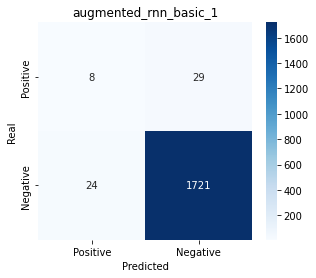

accuracy  : 97.03
precision : [98.34 25.  ]
recall    : [98.62 21.62]
f1_score  : [98.48 23.19]

2th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 21, 191) (7128, 1)
check scale: 0.0 1.0

test: (1782, 21, 191) (1782, 1)
check scale: -0.08089430894308944 1.1
up-sampled train dataset: (13960, 21, 191) (13960, 1)
model has been restored from ./h5/augmented_rnn_basic_2_100_5_100_cv_2of20.h5


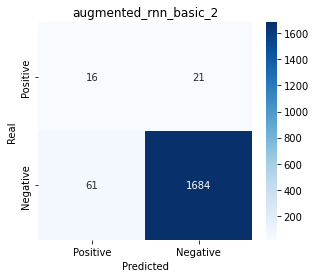

accuracy  : 95.39999999999999
precision : [98.77 20.78]
recall    : [96.5  43.24]
f1_score  : [97.62 28.07]

3th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 21, 191) (7128, 1)
check scale: 0.0 1.0

test: (1782, 21, 191) (1782, 1)
check scale: 0.0 1.2375476320815681
up-sampled train dataset: (13960, 21, 191) (13960, 1)
model has been restored from ./h5/augmented_rnn_basic_2_100_5_100_cv_3of20.h5


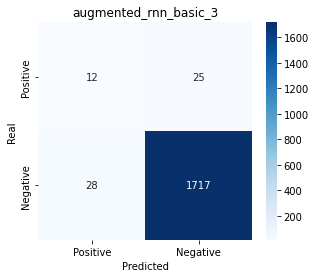

accuracy  : 97.03
precision : [98.56 30.  ]
recall    : [98.4  32.43]
f1_score  : [98.48 31.17]

4th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 21, 191) (7128, 1)
check scale: 0.0 1.0

test: (1782, 21, 191) (1782, 1)
check scale: -0.015855039920292593 1.2375476320815681
up-sampled train dataset: (13960, 21, 191) (13960, 1)
model has been restored from ./h5/augmented_rnn_basic_2_100_5_100_cv_4of20.h5


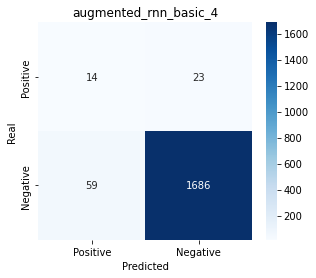

accuracy  : 95.39999999999999
precision : [98.65 19.18]
recall    : [96.62 37.84]
f1_score  : [97.63 25.45]

5th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 21, 191) (7128, 1)
check scale: 0.0 1.0

test: (1782, 21, 191) (1782, 1)
check scale: 0.0 1.1340206178027525
up-sampled train dataset: (13960, 21, 191) (13960, 1)
model has been restored from ./h5/augmented_rnn_basic_2_100_5_100_cv_5of20.h5


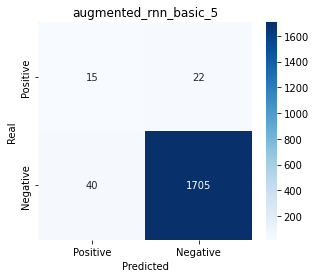

accuracy  : 96.52
precision : [98.73 27.27]
recall    : [97.71 40.54]
f1_score  : [98.21 32.61]

6th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 21, 191) (7128, 1)
check scale: 0.0 1.0

test: (1782, 21, 191) (1782, 1)
check scale: 0.0 1.08424866676003
up-sampled train dataset: (13960, 21, 191) (13960, 1)
model has been restored from ./h5/augmented_rnn_basic_2_100_5_100_cv_6of20.h5


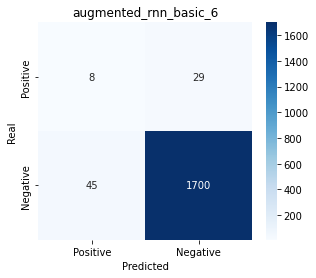

accuracy  : 95.85000000000001
precision : [98.32 15.09]
recall    : [97.42 21.62]
f1_score  : [97.87 17.78]

7th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 21, 191) (7128, 1)
check scale: 0.0 1.0

test: (1782, 21, 191) (1782, 1)
check scale: 0.0 1.2375476320815681
up-sampled train dataset: (13960, 21, 191) (13960, 1)
model has been restored from ./h5/augmented_rnn_basic_2_100_5_100_cv_7of20.h5


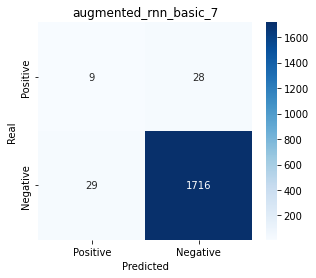

accuracy  : 96.8
precision : [98.39 23.68]
recall    : [98.34 24.32]
f1_score  : [98.37 24.  ]

8th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 21, 191) (7128, 1)
check scale: 0.0 1.0

test: (1782, 21, 191) (1782, 1)
check scale: -0.04339519453794438 1.2375476320815681
up-sampled train dataset: (13960, 21, 191) (13960, 1)
model has been restored from ./h5/augmented_rnn_basic_2_100_5_100_cv_8of20.h5


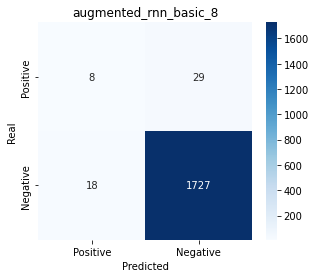

accuracy  : 97.36
precision : [98.35 30.77]
recall    : [98.97 21.62]
f1_score  : [98.66 25.4 ]

9th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 21, 191) (7128, 1)
check scale: 0.0 1.0

test: (1782, 21, 191) (1782, 1)
check scale: -0.04339519453794438 1.2
up-sampled train dataset: (13960, 21, 191) (13960, 1)
model has been restored from ./h5/augmented_rnn_basic_2_100_5_100_cv_9of20.h5


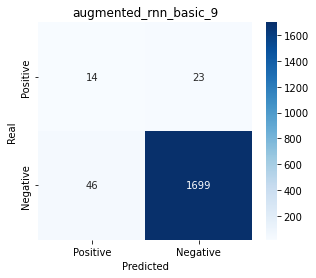

accuracy  : 96.13000000000001
precision : [98.66 23.33]
recall    : [97.36 37.84]
f1_score  : [98.01 28.87]

10th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 21, 191) (7128, 1)
check scale: 0.0 1.0

test: (1782, 21, 191) (1782, 1)
check scale: -0.012412930880514383 1.09064807219032
up-sampled train dataset: (13960, 21, 191) (13960, 1)
model has been restored from ./h5/augmented_rnn_basic_2_100_5_100_cv_10of20.h5


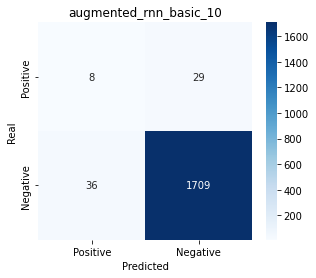

accuracy  : 96.35000000000001
precision : [98.33 18.18]
recall    : [97.94 21.62]
f1_score  : [98.13 19.75]

11th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 21, 191) (7128, 1)
check scale: 0.0 1.0

test: (1782, 21, 191) (1782, 1)
check scale: 0.0 1.0055897149245387
up-sampled train dataset: (13960, 21, 191) (13960, 1)
model has been restored from ./h5/augmented_rnn_basic_2_100_5_100_cv_11of20.h5


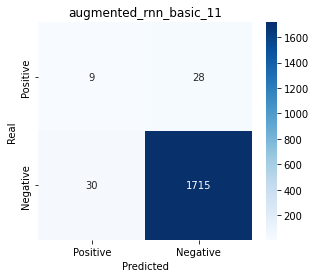

accuracy  : 96.75
precision : [98.39 23.08]
recall    : [98.28 24.32]
f1_score  : [98.34 23.68]

12th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 21, 191) (7128, 1)
check scale: 0.0 1.0

test: (1782, 21, 191) (1782, 1)
check scale: -0.04339519453794438 1.2
up-sampled train dataset: (13960, 21, 191) (13960, 1)
model has been restored from ./h5/augmented_rnn_basic_2_100_5_100_cv_12of20.h5


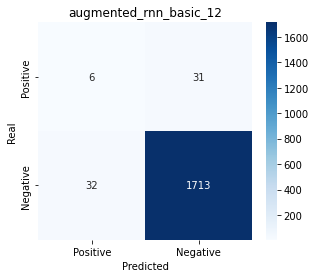

accuracy  : 96.46000000000001
precision : [98.22 15.79]
recall    : [98.17 16.22]
f1_score  : [98.19 16.  ]

13th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 21, 191) (7128, 1)
check scale: 0.0 1.0

test: (1782, 21, 191) (1782, 1)
check scale: 0.0 1.1
up-sampled train dataset: (13960, 21, 191) (13960, 1)
model has been restored from ./h5/augmented_rnn_basic_2_100_5_100_cv_13of20.h5


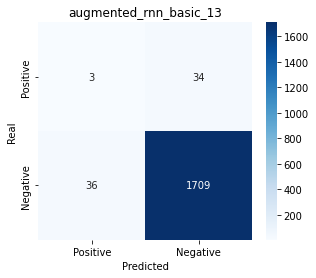

accuracy  : 96.07
precision : [98.05  7.69]
recall    : [97.94  8.11]
f1_score  : [97.99  7.89]

14th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 21, 191) (7128, 1)
check scale: 0.0 1.0

test: (1782, 21, 191) (1782, 1)
check scale: 0.0 1.2211713573105463
up-sampled train dataset: (13960, 21, 191) (13960, 1)
model has been restored from ./h5/augmented_rnn_basic_2_100_5_100_cv_14of20.h5


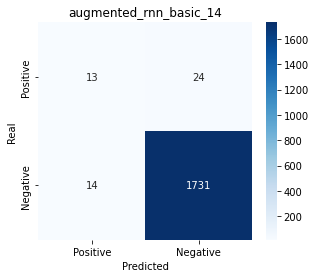

accuracy  : 97.87
precision : [98.63 48.15]
recall    : [99.2  35.14]
f1_score  : [98.91 40.62]

15th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 21, 191) (7128, 1)
check scale: 0.0 1.0

test: (1782, 21, 191) (1782, 1)
check scale: -0.04339519453794438 1.115612477689318
up-sampled train dataset: (13960, 21, 191) (13960, 1)
model has been restored from ./h5/augmented_rnn_basic_2_100_5_100_cv_15of20.h5


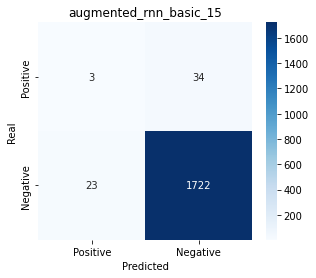

accuracy  : 96.8
precision : [98.06 11.54]
recall    : [98.68  8.11]
f1_score  : [98.37  9.52]

16th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 21, 191) (7128, 1)
check scale: 0.0 1.0

test: (1782, 21, 191) (1782, 1)
check scale: -0.04339519453794438 1.2375476320815681
up-sampled train dataset: (13960, 21, 191) (13960, 1)
model has been restored from ./h5/augmented_rnn_basic_2_100_5_100_cv_16of20.h5


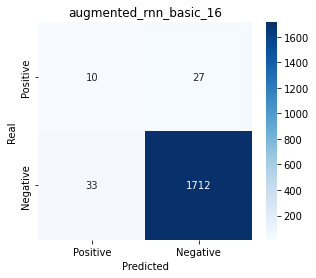

accuracy  : 96.63000000000001
precision : [98.45 23.26]
recall    : [98.11 27.03]
f1_score  : [98.28 25.  ]

17th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 21, 191) (7128, 1)
check scale: 0.0 1.0

test: (1782, 21, 191) (1782, 1)
check scale: 0.0 1.2
up-sampled train dataset: (13960, 21, 191) (13960, 1)
model has been restored from ./h5/augmented_rnn_basic_2_100_5_100_cv_17of20.h5


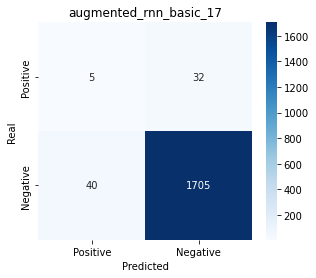

accuracy  : 95.96000000000001
precision : [98.16 11.11]
recall    : [97.71 13.51]
f1_score  : [97.93 12.2 ]

18th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 21, 191) (7128, 1)
check scale: 0.0 1.0

test: (1782, 21, 191) (1782, 1)
check scale: -0.002411714039621026 1.2492054421037964
up-sampled train dataset: (13960, 21, 191) (13960, 1)
model has been restored from ./h5/augmented_rnn_basic_2_100_5_100_cv_18of20.h5


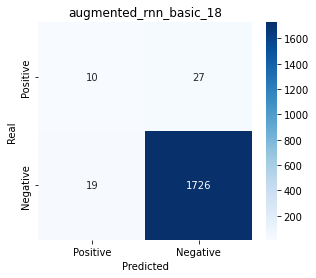

accuracy  : 97.42
precision : [98.46 34.48]
recall    : [98.91 27.03]
f1_score  : [98.68 30.3 ]

19th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 21, 191) (7128, 1)
check scale: 0.0 1.0

test: (1782, 21, 191) (1782, 1)
check scale: 0.0 1.2
up-sampled train dataset: (13960, 21, 191) (13960, 1)
model has been restored from ./h5/augmented_rnn_basic_2_100_5_100_cv_19of20.h5


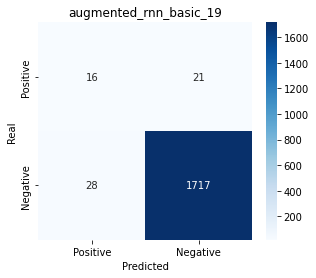

accuracy  : 97.25
precision : [98.79 36.36]
recall    : [98.4  43.24]
f1_score  : [98.59 39.51]

20th iteration
train/test dataset: <class 'numpy.ndarray'>

train: (7128, 21, 191) (7128, 1)
check scale: 0.0 1.0

test: (1782, 21, 191) (1782, 1)
check scale: -0.04339519453794438 1.2375476320815681
up-sampled train dataset: (13960, 21, 191) (13960, 1)
model has been restored from ./h5/augmented_rnn_basic_2_100_5_100_cv_20of20.h5


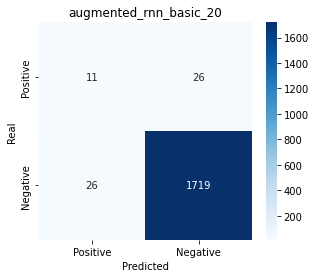

accuracy  : 97.08
precision : [98.51 29.73]
recall    : [98.51 29.73]
f1_score  : [98.51 29.73]


In [18]:
from src.graph_plot import *

for i in range(n_cv):
    print(f"\n{i+1}th iteration")
    random.seed(i+1)
    train_x, train_y, test_x, test_y, _, _ = stratified_split(rnn_input, rnn_output, 
                                                          test_size=test_size, random_state=i+1, 
                                                          scale_x=x_cts, scale_y=[])
    train_x, train_y = up_sampling(train_x, train_y)

    history_size = train_x.shape[1]
    x_dim = train_x.shape[2]
    y_dim = train_y.shape[1]
    save_path  = f'./h5/{model_name}_{rnn_layers}_{rnn_neurons}_{dnn_layers}_{dnn_neurons}_cv_{i+1}of{n_cv}.h5'

    model = RNN(history_size, x_dim, y_dim)
    model.build(rnn_layers, rnn_neurons, dnn_layers, dnn_neurons)
    model.load_model(save_path)
    
    prediction = model.model.predict(test_x, verbose=0)
    y_pred = prediction.round(0).astype(int)
    y_real = test_y
    
    plot_confusion(y_real, y_pred, title=model_name+f"_{i+1}", label=["Positive","Negative"])